### Caclulating Formation Porosity and Overburden Stress ###

With a density log, we will determine the formation porosity (PHID) and overburden stress (Sv) for an offshore exploration well in the Gulf of Mexico (GOM). Then we will plot the results and note what the attributes may be telling us about the subsurface. This is not meant to be an exhaustive treatment of resevoir geomechanics and petrophysics. Rather, it is meant to illustrate basic concepts with an interactive notebook. 

Data used in this notebook is sourced from Stanford's Resevoir Geomechanics MOOC: https://lagunita.stanford.edu/courses/course-v1:EarthSciences+ResGeo202+Spring2019/about

In [33]:
import numpy as np
import matplotlib.pyplot as plt

### Load log data, add water column and shallow sediments ###

Density log being loaded has 2 tracks:
1. depth track (ft)
2. density curve (g/cc)
    
The first measurement is at 3515ft into the subsurface. For a complete look at the overburden stress we need to add in the water column and shallow sediments above to the logged interval. We will use a constant density of 1.0 g/cc for water and 1.8 g/cc for sediments. 

In [49]:
# load log data
logMD = np.loadtxt('GOM_Data.txt',delimiter='\t',usecols=0,skiprows=1)
logDEN = np.loadtxt('GOM_Data.txt',delimiter='\t',usecols=1,skiprows=1)

# make an array filled with the mean density
#logDEN_mean = np.full(logMD.shape,logDEN.mean())

# make water density and column height arrays
waterMD = np.arange(1,1000,1)
waterDEN = np.full((waterMD.shape),1.0)

# make shallow sediment density and thickness arrays 
sedMD = np.arange(1001,int(logMD[0]-1),1)
sedDEN = np.full((sedMD.shape),1.8)

# concatenate the seperate tracks together
argsMD = (waterMD,sedMD,logMD)
argsDEN = (waterDEN,sedDEN,logDEN)
#argsDEN_mean = (waterDEN,sedDEN,logDEN_mean)

gomMD = np.concatenate((argsMD))
gomDEN = np.concatenate((argsDEN))
#gomDEN_mean = np.concatenate((argsDEN_mean))

In [50]:
gomMD.shape

(13098,)

### Calculate formation porosity (PHID) from the GOM density log ###

PHID equation pulled from Crain's Petrophysical Handbook: https://www.spec2000.net/12-phidn.htm

PHID = (logDEN - matrixDEN ) / (waterDEN - matrixDEN)

Note: this equation assumes constant matrix density. 

In [51]:
matrixDEN=2.7 #g/cc, standard sedimentary rock density
waterDEN=1.0 #g/cc

gomPHID=(gomDEN-matrixDEN)/(waterDEN-matrixDEN)

print('GOM porosity at 10000ft = {:.4f}'.format(float(gomPHID[(gomMD==10000)])))

GOM porosity at 10000ft = 0.1976


In [52]:
gomPHID.shape

(13098,)

### Compute the rolling averages for density and porosity ###
We will plot the rolling means on top of their respective curves. This will help us see step changes in the attributes.

Note that the rolling mean will be sligthly shifted down hole. This is due to the nature of the rolling window approach implemented. Each point is the mean of n and n+N points across the window. The window runs downwards into the subsurface, thus the computed mean is pulled to lower edge of the window.    

In [53]:
def rolling_mean(x, N):
    """
    compute the running mean for a 1-D array (x) over a given window (N) 
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [54]:
filler = np.full(99,1.0)
gomDEN_rolling = np.concatenate((filler,rolling_mean(gomDEN,100)),axis=0)
gomPHID_rolling = np.concatenate((filler,rolling_mean(gomPHID,100)),axis=0)

In [55]:
print(gomDEN_rolling.shape)
print(gomPHID_rolling.shape)
print(filler.shape)

(13098,)
(13098,)
(99,)


### Calculate overburden and pore pressure. Convert from mPa to psi. Calculate the stress gradient. ###

The Sv(z) is again pulled from Crain's Petrophyscial Handbook: https://www.spec2000.net/10-pressure.htm  

Sv(z) = waterDEN * waterCOL * g + gomDEN_mean * g(waterCOL-gomMD)

Pp(z) = waterDEN * waterCOL * g + poreDEN * g(waterCOL-gomMD)

Note: this equation is the approximation the integral of density taken with respect to depth.

In [56]:
g = 32.17 #ft/s^2
poreDEN = 1.0 #g/cc
waterDEN = 1.0 #g/cc
convert = 0.0145038 #convert mPa to PSI

gomSv = ((waterDEN*g*1000)+(gomDEN_rolling*g*(gomMD-1000)))*convert
gomPP = ((waterDEN*g*1000)+(poreDEN*g*(gomMD-1000)))*convert
gomSv_gradient = gomSv/gomMD

print('GOM vertical stress at 10,000ft = {:.4f}'.format(float(gomSv[(gomMD==10000)])))
print('GOM pore pressure at 10,000ft = {:.4f}'.format(float(gomPP[(gomMD==10000)])))
print('GOM overburden gradient at 10,000ft = {:.4f}'.format(float(gomSv_gradient[(gomMD==10000)])))

GOM vertical stress at 10,000ft = 10365.1004
GOM pore pressure at 10,000ft = 4665.8725
GOM overburden gradient at 10,000ft = 1.0365


### Bring it all together: Plot the data  
#### Plot GOM density and porosity curves
Plot the recorded density, computed porosity, and the rolling means. Addtionally, lets tune plot attributes to draft a clean figure.

#### Plot GOM overburden Sv stress and overburden stress gradient
Plot the overburden, pore pressure, and the overburden gradient. We will draft the figure with same approach as above.

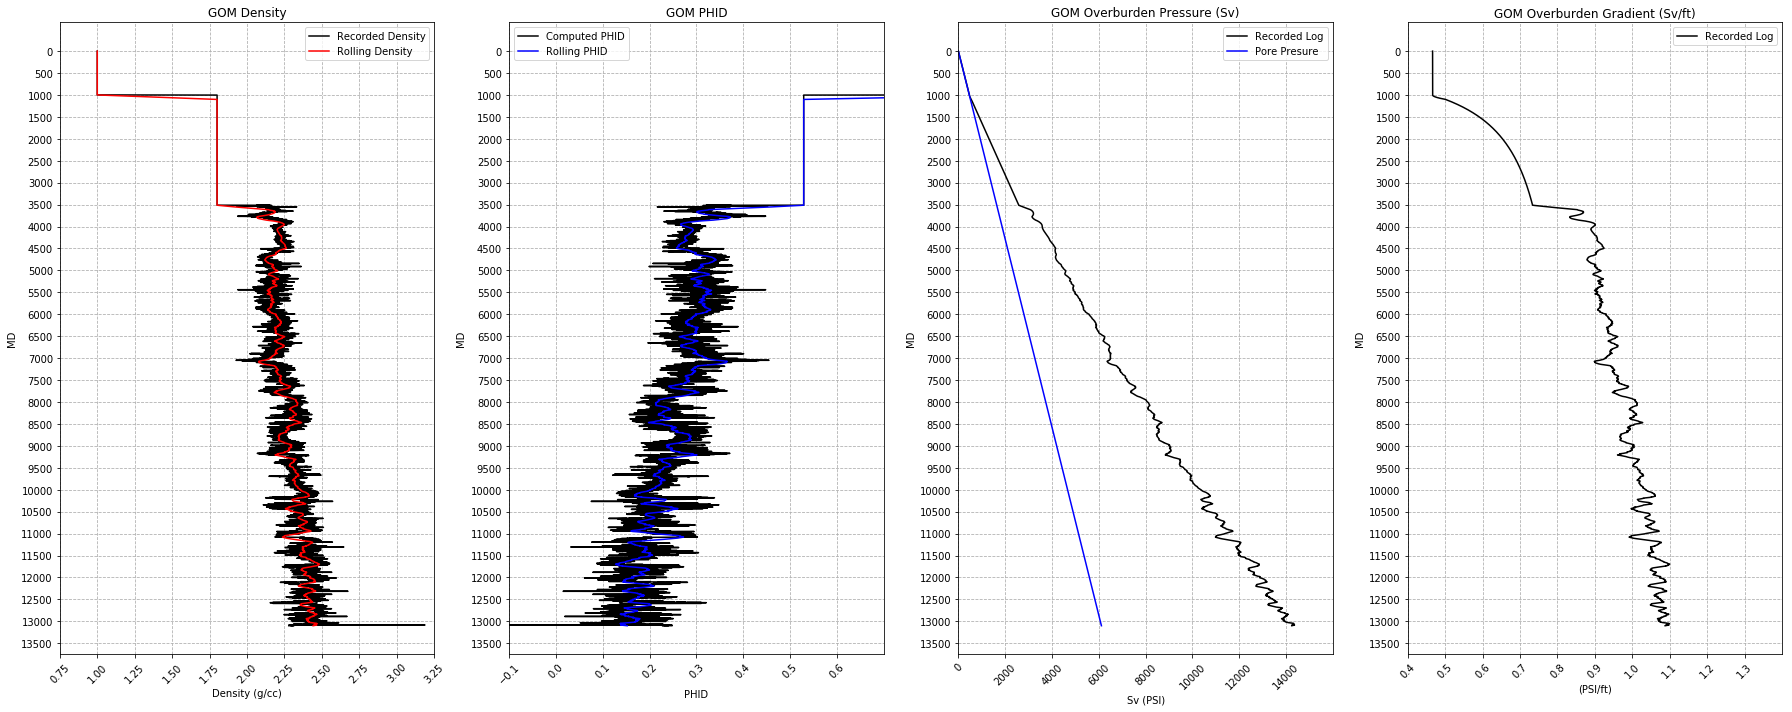

In [57]:
plt.figure(figsize=(25,10))

plt.subplot(1,4,1)
plt.gca().invert_yaxis()
plt.gca().grid(True,linestyle='--')
plt.plot(gomDEN,gomMD,color='black',label='Recorded Density')
plt.plot(gomDEN_rolling,gomMD,color='red',label='Rolling Density')
plt.title('GOM Density')
plt.yticks(np.arange(0, 14000, 500))
plt.xlim(0.75,3.25)
plt.xticks(np.arange(0.75, 3.5, 0.25),rotation=45)
plt.xlabel('Density (g/cc)')
plt.ylabel('MD')
plt.legend(loc=1)

plt.subplot(1,4,2)
plt.gca().invert_yaxis()
plt.gca().grid(True, linestyle='--')
plt.plot(gomPHID, gomMD, color='black',label='Computed PHID')
plt.plot(gomPHID_rolling, gomMD, color='blue',label='Rolling PHID')
plt.title('GOM PHID')
plt.yticks(np.arange(0, 14000, 500))
plt.xlim(-0.10,0.7)
plt.xticks(np.arange(-0.10, 0.7, 0.10),rotation=45)
plt.xlabel('PHID')
plt.ylabel('MD')
plt.legend(loc=2)

plt.subplot(1,4,3)
plt.gca().invert_yaxis()
plt.gca().grid(True,linestyle='--')
plt.plot(gomSv,gomMD,color='black',label='Recorded Log')
plt.plot(gomPP,gomMD,color='blue',label='Pore Presure')
plt.title('GOM Overburden Pressure (Sv)')
plt.yticks(np.arange(0, 14000, 500))
plt.xlim(0,16000)
plt.xticks(np.arange(0, 16000, 2000),rotation=45)
plt.xlabel('Sv (PSI)')
plt.ylabel('MD')
plt.legend(loc=1)

plt.subplot(1,4,4)
plt.gca().invert_yaxis()
plt.gca().grid(True,linestyle='--')
plt.plot(gomSv_gradient,gomMD,color='black',label='Recorded Log')
#plt.plot(gomPP,gomMD,color='blue',label='Pore Presure')
plt.title('GOM Overburden Gradient (Sv/ft)')
plt.yticks(np.arange(0, 14000, 500))
plt.xlim(0.4,1.4)
plt.xticks(np.arange(0.4, 1.4, 0.10),rotation=45)
plt.xlabel('(PSI/ft)')
plt.ylabel('MD')
plt.legend(loc=1)

plt.tight_layout()

### Bring it all together: Evaluate the data 

At a broad scale note that as we head deeper into the subsurface:
1. Density increases, regardless of rock type or fluids present
2. Porosity decreases, again regardless of rock or fluid type
3. The difference between between pore pressure and Sv increases with depth
4. The average Sv gradient is roughly 1.0 PSI/ft

At a finer scale note that as we head deeper into the subsurface:
1. Guided by rolling density, different density units can be identified within the section
2. When there is a decrease in density there is a 5-10% increase in porosity
3. Sv increases rapidly at depth with 500-1000PSI pressure swings beyond 11,000'MD 
4. The Sv gradient changes at roughly 3500', 7500', and 10,000'MD. 

With the plots above we can begin to define the state of stress in a resevoir and the rock above it. With this information we can begin to develop a strategy to handle the pressures encountered while drilling and completing this resevoir. Next steps include... effective pressure.